# MDS and clustering: an experimental pipeline to identify relevant characteristics in COVID-19 prognosis

- Constanza Marini Macouzet -- A01332485
- Diana Laura Aguilar Cervantes -- A01751168

COVID-19 is an acute respiratory illness that threatens global health and has already affected many people's lives. Motivated by this, in this notebook, we present an experimental pipeline to extract information from a COVID-19 dataset.

## The data

We chose a dataset from Kaggle. Its name is _Coronavirus disease 2019 (COVID-19) India_. It contains clinical, personal and regional information of patients with probable COVID-19 from India. 

In [1]:
import pandas as pd

In [157]:
train_india = pd.read_csv('train_india.csv')
test_india = pd.read_csv('test_india.csv')

We visualize the attributes of the training set. 

In [3]:
train_india.columns

Index(['people_ID', 'Region', 'Gender', 'Designation', 'Name', 'Married',
       'Children', 'Occupation', 'Mode_transport', 'cases/1M', 'Deaths/1M',
       'comorbidity', 'Age', 'Coma score', 'Pulmonary score',
       'cardiological pressure', 'Diuresis', 'Platelets', 'HBB', 'd-dimer',
       'Heart rate', 'HDL cholesterol', 'Charlson Index', 'Blood Glucose',
       'Insurance', 'salary', 'FT/month', 'Infect_Prob'],
      dtype='object')

We visualize the attributes of the test set.

In [4]:
test_india.columns

Index(['people_ID', 'Region', 'Gender', 'Designation', 'Name', 'Married',
       'Children', 'Occupation', 'Mode_transport', 'cases/1M', 'Deaths/1M',
       'comorbidity', 'Age', 'Coma score', 'Pulmonary score',
       'cardiological pressure', 'Diuresis', 'Platelets', 'HBB', 'd-dimer',
       'Heart rate', 'HDL cholesterol', 'Charlson Index', 'Blood Glucose',
       'Insurance', 'salary', 'FT/month'],
      dtype='object')

Evidently, the training set has a column that the test set does not: Infect_Prob, that is, the probability of the patient to get infected by SARS-CoV-2. Thus, our experiments will follow two different lines: one in which we will leverage and study the probability of infection, using the training set, and the other with the test set. 

Let us begin by changing the name of our variables.

In [158]:
set_1 = train_india
set_2 = test_india

## Case study 1

In this line, we will analyze the set that does have a ground-truth label, that is, Infect_Prob. We will start by cleaning up the dataset.

We remove irrelevant attributes, and establish the column names.

In [6]:
df_set1 = set_1[set_1.columns.drop(['Name', 'Designation', 'people_ID'])]
col_names = ['Region', 'Gender', 'Married', 'Children', 'Occupation', 'Mode_transport', 'cases_1M', 'Deaths_1M',
       'comorbidity', 'Age', 'Coma_score', 'Pulmonary_score',
       'cardiological_pressure', 'Diuresis', 'Platelets', 'HBB', 'd_dimer',
       'Heart_rate', 'HDL_cholesterol', 'Charlson_Index', 'Blood_Glucose',
       'Insurance', 'salary', 'FT_month', 'Infect_Prob']
df_set1.columns = col_names
df_set1.shape

(10714, 25)

This is now what our set looks like.

In [7]:
df_set1.head()

Region  Gender Married  Children     Occupation Mode_transport  \
0  Bhubaneshwar  Female     YES       1.0         Farmer         Public   
1  Bhubaneshwar  Female     YES       2.0         Farmer           Walk   
2  Bhubaneshwar  Female      NO       1.0        Cleaner         Public   
3  Bhubaneshwar  Female     YES       1.0         Driver            Car   
4  Bhubaneshwar  Female      NO       2.0  Manufacturing            Car   

   cases_1M  Deaths_1M             comorbidity  Age  ...    HBB d_dimer  \
0         2          0            Hypertension   68  ...   93.0   233.0   
1         2          0                Diabetes   64  ...   56.0   328.0   
2         2          0                    None   19  ...  137.0   213.0   
3         2          0  Coronary Heart Disease   33  ...  167.0   275.0   
4         2          0                Diabetes   23  ...  153.0   331.0   

  Heart_rate  HDL_cholesterol  Charlson_Index  Blood_Glucose  Insurance  \
0       82.0             58.0              27              7  3600000.0   
1       89.0             68.0               5              6  1600000.0   
2       77.0             43.0              40              6  3400000.0   
3       64.0             60.0              27              7   700000.0   
4       71.0             64.0              32              7  3200000.0   

    salary  FT_month  Infect_Prob  
0  1300000       2.0    49.135010  
1   400000       1.0    51.147880  
2   900000       1.0    73.224000  
3  2300000       1.0    48.779225  
4  1100000       1.0    87.868800  

[5 rows x 25 columns]

We check if there are missing values in the dataset.

In [8]:
df_set1.isna().sum().sum()

7116

As there are too many missing values, we use the package MICE from R to fill them. What this package does is impute incomplete multivariate data by chained equations. According to [1], Multiple imputation is what one should try when dealing with complex incomplete data problems.  

In [9]:
col_names = list(df_set1.columns)
df_set1_np = df_set1.to_numpy()

As we needed R, we executed this part of the process in the console. We add the code we utilized to obtain the file completeData_train_india.csv. This file contains the complete training dataset after mice from R imputed the initial missing values.

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
library(mice)
library(plyr)

In [ ]:
%Rpush df_set1_np
%Rpush col_names

In [ ]:
%%R
print(class(df_set1_np))
print(length(df_set1_np))

In [ ]:
%%R
df_set1_r <- data.frame(matrix(unlist(df_set1_np), nrow=length(df_set1_np), byrow=T), stringsAsFactors=TRUE)
colnames(df_set1_r) <- col_names

In [ ]:
%%R
df_set1_r[df_set1_r == 'NaN'] <- NA
sum(is.na(df_set1_r))

In [ ]:
%%R
print(class(df_set1_r))
head(df_set1_r[1:2,])

In [ ]:
%%R
tempData <- mice(df_set1_r, m=3, seed=12345, maxit=3, meth='cart')

In [ ]:
%%R
df_set1_complete <- complete(tempData, 1)

In [ ]:
%Rpull df_set1_complete

We can go back to Python to import the complete dataset. We check for missing values, and after using mice from R, we have none.

In [10]:
df_set1_c = pd.read_csv('completeData_train_india.csv')
df_set1_c.isna().sum().sum()

0

In [11]:
df_set1_c.head()

Region  Gender Married  Children     Occupation Mode_transport  \
0  Bhubaneshwar  Female     YES         1         Farmer         Public   
1  Bhubaneshwar  Female     YES         2         Farmer           Walk   
2  Bhubaneshwar  Female      NO         1        Cleaner         Public   
3  Bhubaneshwar  Female     YES         1         Driver            Car   
4  Bhubaneshwar  Female      NO         2  Manufacturing            Car   

   cases_1M  Deaths_1M             comorbidity  Age  ...  HBB d_dimer  \
0         2          0            Hypertension   68  ...   93     233   
1         2          0                Diabetes   64  ...   56     328   
2         2          0                    None   19  ...  137     213   
3         2          0  Coronary Heart Disease   33  ...  167     275   
4         2          0                Diabetes   23  ...  153     331   

  Heart_rate  HDL_cholesterol  Charlson_Index  Blood_Glucose  Insurance  \
0         82               58              27              7  3600000.0   
1         89               68               5              6  1600000.0   
2         77               43              40              6  3400000.0   
3         64               60              27              7   700000.0   
4         71               64              32              7  3200000.0   

    salary  FT_month  Infect_Prob  
0  1300000         2    49.135010  
1   400000         1    51.147880  
2   900000         1    73.224000  
3  2300000         1    48.779225  
4  1100000         1    87.868800  

[5 rows x 25 columns]

We start preprocessing our data by replacing some attribute values with a binary transformation.

In [12]:
df_set1_c.Married.replace(to_replace=dict(YES=1, NO=0), inplace=True)
df_set1_c.Gender.replace(to_replace=dict(Male=0, Female=1), inplace=True)
df_set1_c['Pulmonary_score'].replace(['<100', '<200', '<300', '<400'], [100, 200, 300, 400], inplace=True)
df_set1_c.head()

Region  Gender  Married  Children     Occupation Mode_transport  \
0  Bhubaneshwar       1        1         1         Farmer         Public   
1  Bhubaneshwar       1        1         2         Farmer           Walk   
2  Bhubaneshwar       1        0         1        Cleaner         Public   
3  Bhubaneshwar       1        1         1         Driver            Car   
4  Bhubaneshwar       1        0         2  Manufacturing            Car   

   cases_1M  Deaths_1M             comorbidity  Age  ...  HBB  d_dimer  \
0         2          0            Hypertension   68  ...   93      233   
1         2          0                Diabetes   64  ...   56      328   
2         2          0                    None   19  ...  137      213   
3         2          0  Coronary Heart Disease   33  ...  167      275   
4         2          0                Diabetes   23  ...  153      331   

  Heart_rate  HDL_cholesterol  Charlson_Index  Blood_Glucose  Insurance  \
0         82               58              27              7  3600000.0   
1         89               68               5              6  1600000.0   
2         77               43              40              6  3400000.0   
3         64               60              27              7   700000.0   
4         71               64              32              7  3200000.0   

    salary  FT_month  Infect_Prob  
0  1300000         2    49.135010  
1   400000         1    51.147880  
2   900000         1    73.224000  
3  2300000         1    48.779225  
4  1100000         1    87.868800  

[5 rows x 25 columns]

Now, we create some masks for encoding.

In [13]:
msk_cat = df_set1_c.dtypes == 'object'
msk_num = df_set1_c.dtypes != 'object'

We encode and transform the attributes. We use One hot encoder from scikit learn on the categorical attributes as suggested in [2], and use a logaritmic transformation on the numerical attributes as stated in [3].

In [14]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import scipy.sparse

In [15]:
enc = OneHotEncoder(sparse = True, handle_unknown = 'ignore')
set1 = df_set1_c.iloc[:, :-1]
enc_cat_data = enc.fit_transform(set1.loc[:, msk_cat])
enc_num_data = np.log10(set1.loc[:, msk_num] + 1)
set1_enc = scipy.sparse.hstack([enc_num_data, enc_cat_data])
set1_enc.shape

(10714, 44)

Now, we create a target vector and apply the logaritmic transformation as well.

In [16]:
y_original = df_set1_c.iloc[:,-1]
y_s1 = np.log10(y_original + 1)
y_s1.head()
y_s1.shape

(10714,)

Then, we leverage MDS. It stands for Multidimensional Scaling, and it is an analysis technique that allows to represent high-dimensional data into lower space without losing its intrinsic information [4]. 

In [17]:
from sklearn.manifold import MDS

In [ ]:
results_train = MDS(n_components = 2, metric = True, n_init = 4, max_iter = 300, verbose = 0, eps = 0.001, n_jobs = None, random_state = 970, dissimilarity = 'euclidean').fit(set1_enc.toarray())

It takes a long time to obtain these results, therefore, we save them so as to save time in further tests.

In [ ]:
df_MDS1 = pd.DataFrame(data = results_train.embedding_)
df_MDS1.to_csv('set1_MDS.csv')

We will now work with results from the file.

In [17]:
MDS_set1 = pd.read_csv('set1_MDS.csv')

In [18]:
MDS_set1 = MDS_set1.iloc[:,1:]

In [19]:
MDS_set1.head()

0         1
0  0.947948 -1.115155
1 -0.434093  2.026101
2  1.188454 -0.633180
3  0.088776 -0.090805
4  0.300023  0.622374

Now, we visualize the data. 

In [20]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

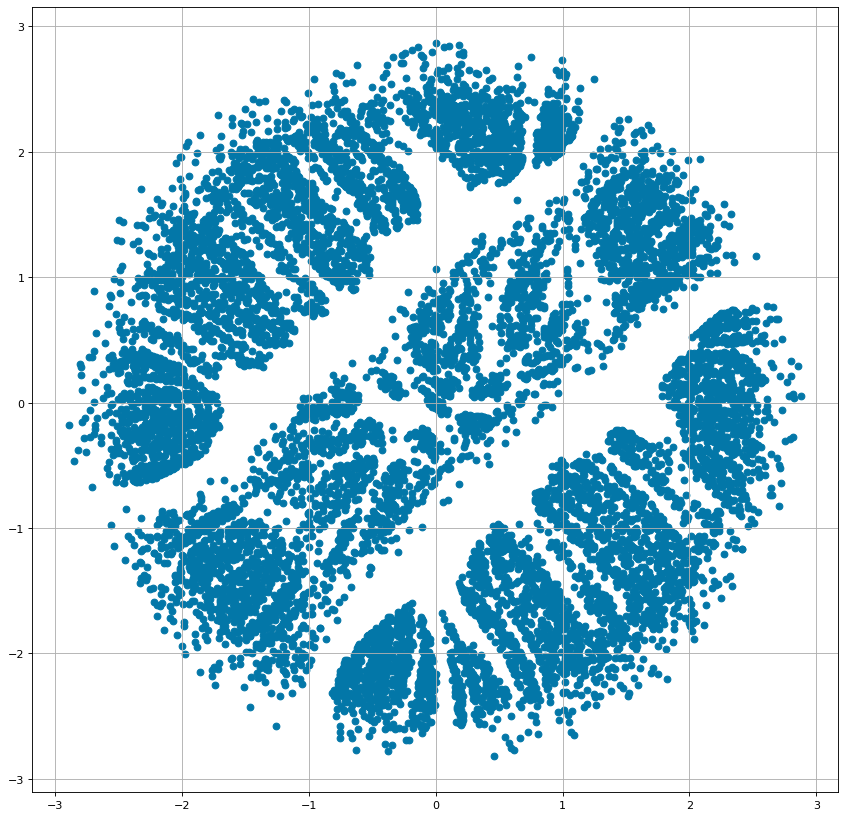

In [139]:
figure(num = None, figsize = (13, 13), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.scatter(MDS_set1.iloc[:, 0], MDS_set1.iloc[:, 1], marker='o', color='#0377a8')
plt.grid()
plt.savefig('MDS1.png')
plt.show()

Initially, we will show how the probability of infection varies within the whole data. Thus, we will use the probability associated to each observation and show this values with a heatmap. 

In [22]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
colors = ['#b4fadc', '#0377a8']
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

We normalize the probabilities first.

In [23]:
probabilities = y_s1.values
n_probabilities = probabilities / sum(probabilities)

Now, we show the results. Light tones are related to low probabilities and darker tones to high probabilities. 

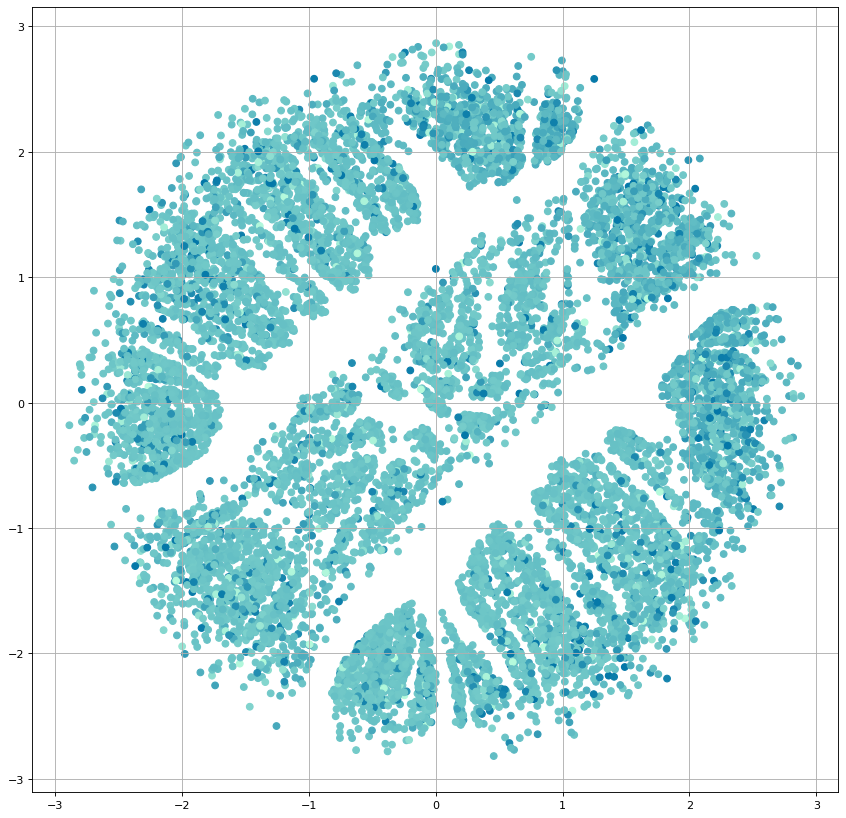

In [134]:
figure(num = None, figsize = (13, 13), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.scatter(MDS_set1.values[:, 0], MDS_set1.values[:, 1], c = n_probabilities, cmap = cmap1 , marker='o')
plt.savefig('prob1.png')
plt.grid()

This graph sets the basis to construct a clustering model so as to work on a intra-cluster probability analysis. We will follow the experimental pipeline suggested in [5]. Thus, we will use K-means and use the  Silhouette average values to determine the optimal k value.

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [26]:
range_n_clusters = range(2, 15)

In [27]:
silhouette_array = []
for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(MDS_set1)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(MDS_set1, cluster_labels)
    silhouette_array.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.3642779359094602
For n_clusters = 3 The average silhouette_score is : 0.4030349925504181
For n_clusters = 4 The average silhouette_score is : 0.40534087929849116
For n_clusters = 5 The average silhouette_score is : 0.39745559024348415
For n_clusters = 6 The average silhouette_score is : 0.3912408102677698
For n_clusters = 7 The average silhouette_score is : 0.41852351901218315
For n_clusters = 8 The average silhouette_score is : 0.41925899029086827
For n_clusters = 9 The average silhouette_score is : 0.42910767348873313
For n_clusters = 10 The average silhouette_score is : 0.44566315831240183
For n_clusters = 11 The average silhouette_score is : 0.4476404064297759
For n_clusters = 12 The average silhouette_score is : 0.44331496475873733
For n_clusters = 13 The average silhouette_score is : 0.4416150298987988
For n_clusters = 14 The average silhouette_score is : 0.4259404855835406


We plot now Silhouette average value against k. This graph shows that the best k is 11 as the best value the Silhouette score can have is 1. Thus, the closer to one, the better. 

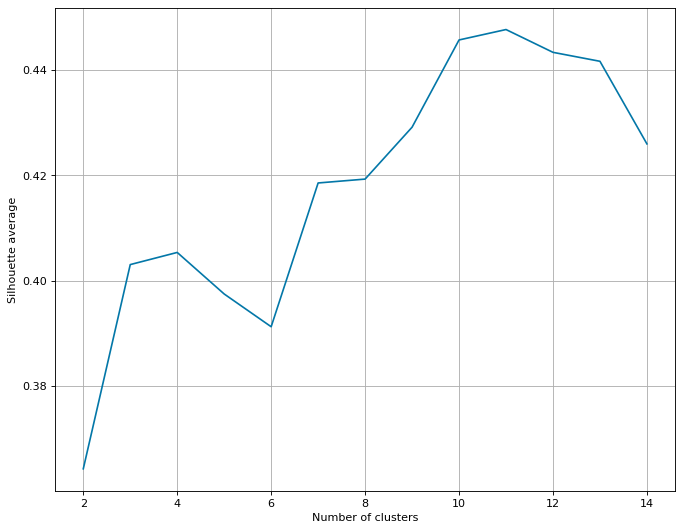

In [137]:
figure(num = None, figsize = (10,8), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.plot(range_n_clusters, silhouette_array, color = '#0377a8')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette average')
plt.savefig('kvss1.png')
plt.grid()

Now, we can apply k-Means, and plot the results. The circles with the numbers mark where the centroids of the clusters are.

In [31]:
import matplotlib.cm as cm

In [32]:
kmeans = KMeans(n_clusters=11, random_state=0).fit(MDS_set1)
cluster_labels = kmeans.fit_predict(MDS_set1)
centers = kmeans.cluster_centers_

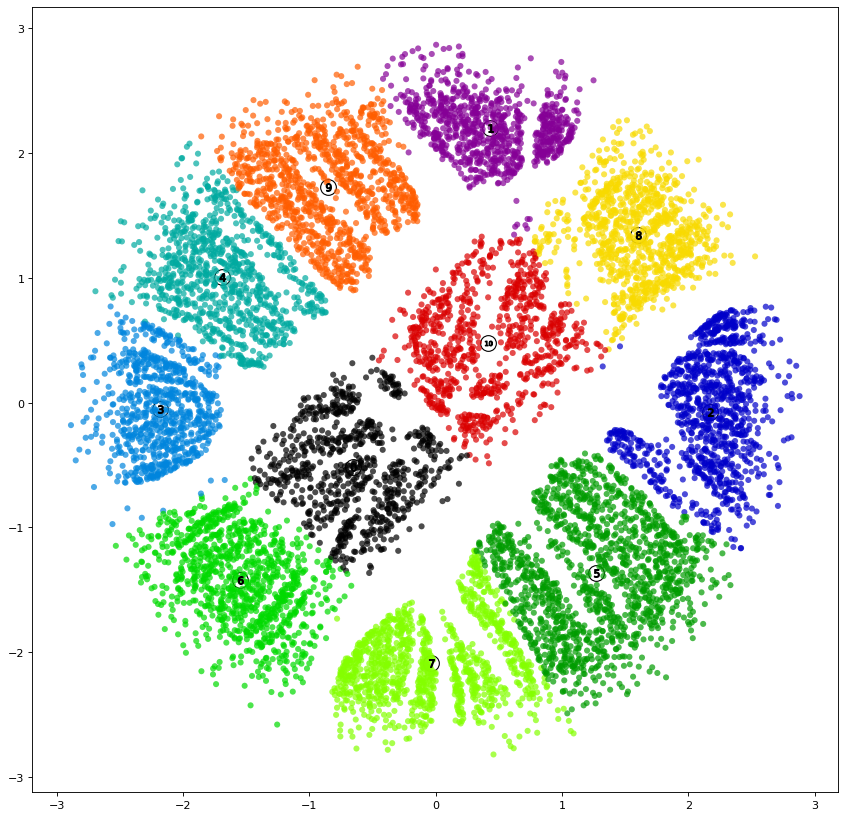

In [141]:
figure(num = None, figsize = (13, 13), dpi = 80, facecolor = 'w', edgecolor = 'k')
colors = cm.nipy_spectral(cluster_labels.astype(float) / 11)
plt.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
plt.scatter(MDS_set1.values[:, 0], MDS_set1.values[:, 1], marker='o', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

for i, c in enumerate(centers):
        plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
plt.savefig('clusters1.png')

Additionally, we plot the Silhouette analysis. We notice that the plot of each cluster is above the mean. 

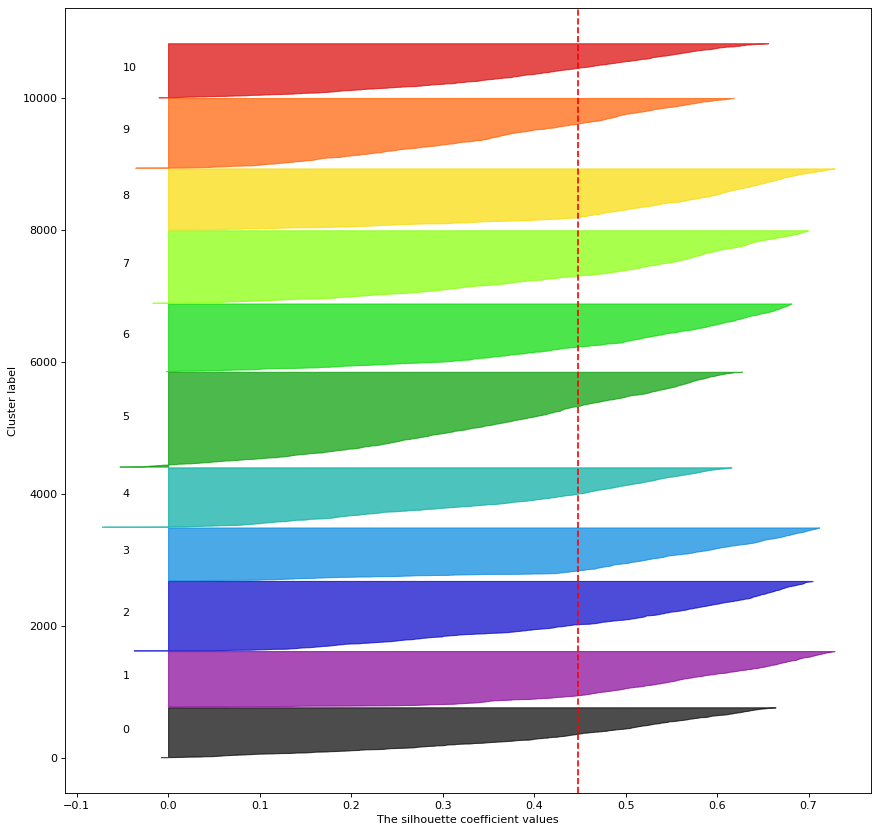

In [164]:
figure(num = None, figsize = (13, 13), dpi = 80, facecolor = 'w', edgecolor = 'k')
silhouette_avg = silhouette_score(MDS_set1, cluster_labels)

sample_silhouette_values = silhouette_samples(MDS_set1, cluster_labels)

y_lower = 10
for i in range(11):    
    ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]

    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 11)
        
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.savefig('sil1.png')

We will proceed to visualize how the probability changes cluster by cluster. 

In [35]:
u_labels1 = set(cluster_labels)

In [36]:
for label in u_labels1:
    index = 'ind1_' + str(label)
    objs = 'obs1_' + str(label)
    pr = 'prob1_' + str(label)
    vars()[index] = []
    vars()[objs] = []
    for i in range(len(cluster_labels)):
        if cluster_labels[i] == label:
            vars()[index].append(i)
            vars()[objs].append(MDS_set1.values[i])
    
    vars()[objs] = np.array(vars()[objs])
    vars()[pr] = n_probabilities[vars()[index]]


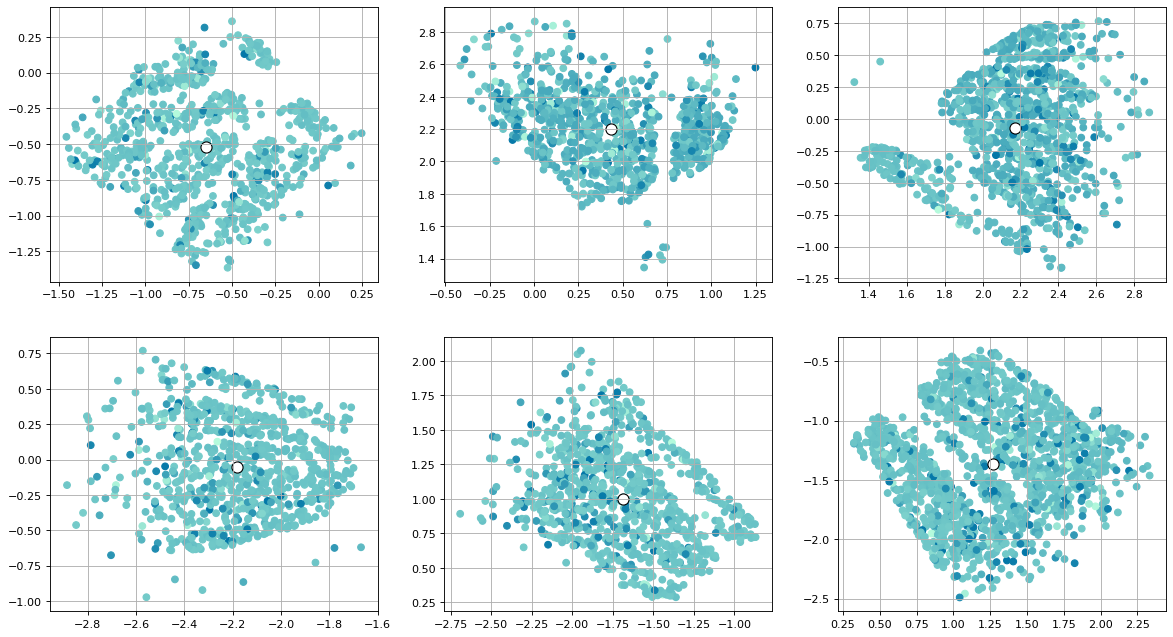

In [151]:
figure(num = None, figsize = (18, 10), dpi = 80, facecolor = 'w', edgecolor = 'k')

plt.subplot(231)
plt.scatter(obs1_0[:, 0], obs1_0[:, 1], c = prob1_0, cmap = cmap1, marker='o')
plt.scatter(centers[0, 0], centers[0, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.subplot(232)
plt.scatter(obs1_1[:, 0], obs1_1[:, 1], c = prob1_1, cmap = cmap1, marker='o')
plt.scatter(centers[1, 0], centers[1, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.subplot(233)
plt.scatter(obs1_2[:, 0], obs1_2[:, 1], c = prob1_2, cmap = cmap1, marker='o')
plt.scatter(centers[2, 0], centers[2, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.subplot(234)
plt.scatter(obs1_3[:, 0], obs1_3[:, 1], c = prob1_3, cmap = cmap1, marker='o')
plt.scatter(centers[3, 0], centers[3, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.subplot(235)
plt.scatter(obs1_4[:, 0], obs1_4[:, 1], c = prob1_4, cmap = cmap1, marker='o')
plt.scatter(centers[4, 0], centers[4, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.subplot(236)
plt.scatter(obs1_5[:, 0], obs1_5[:, 1], c = prob1_5, cmap = cmap1, marker='o')
plt.scatter(centers[5, 0], centers[5, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.savefig('cprob1a.png')

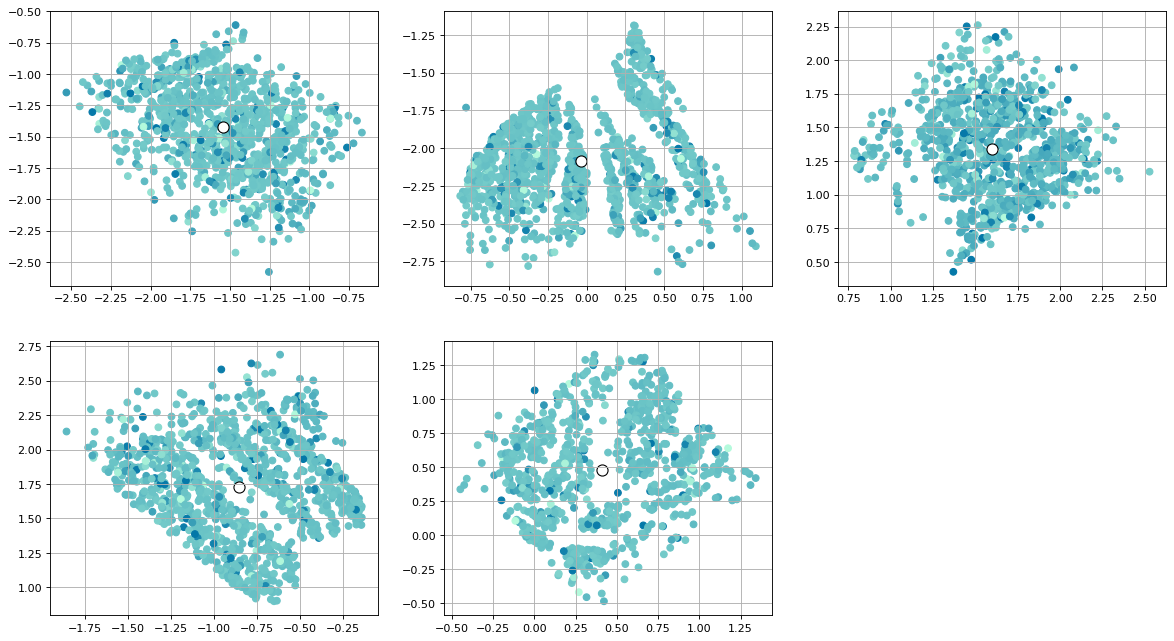

In [154]:
figure(num = None, figsize = (18, 10), dpi = 80, facecolor = 'w', edgecolor = 'k')

plt.subplot(231)
plt.scatter(obs1_6[:, 0], obs1_6[:, 1], c = prob1_6, cmap = cmap1, marker='o')
plt.scatter(centers[6, 0], centers[6, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.subplot(232)
plt.scatter(obs1_7[:, 0], obs1_7[:, 1], c = prob1_7, cmap = cmap1, marker='o')
plt.scatter(centers[7, 0], centers[7, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.subplot(233)
plt.scatter(obs1_8[:, 0], obs1_8[:, 1], c = prob1_8, cmap = cmap1, marker='o')
plt.scatter(centers[8, 0], centers[8, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.subplot(234)
plt.scatter(obs1_9[:, 0], obs1_9[:, 1], c = prob1_9, cmap = cmap1, marker='o')
plt.scatter(centers[9, 0], centers[9, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.subplot(235)
plt.scatter(obs1_10[:, 0], obs1_10[:, 1], c = prob1_10, cmap = cmap1, marker='o')
plt.scatter(centers[10, 0], centers[10, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.savefig('cprob1b.png')

To have a baseline to compare our results with, we will utilize PCA. Here, we will use it to extract the 2 principal components of our data and follow the same procedure as we did with MDS. 

In [39]:
from sklearn.decomposition import PCA

In [40]:
pca = PCA(n_components = 2)
prinComp1 = pca.fit_transform(set1_enc.toarray())

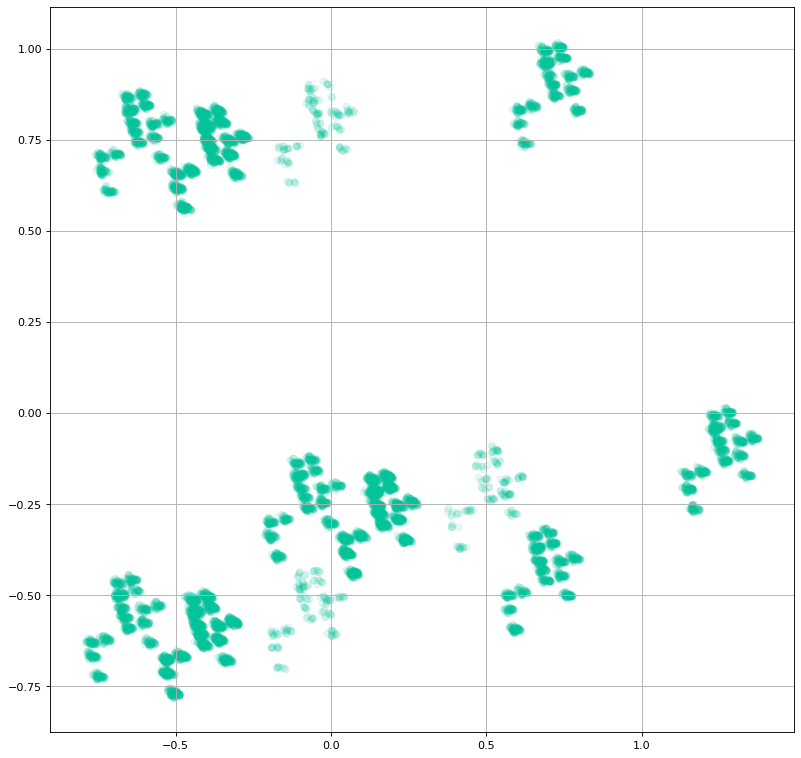

In [42]:
figure(num = None, figsize = (12, 12), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.scatter(prinComp1[:, 0], prinComp1[:, 1], color = '#02c39a', alpha =.1, marker = 'o')
plt.grid()

In [43]:
silhouette_array_PCA1 = []
for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters = n_clusters, random_state=10)
    c_labelsPCA1 = clusterer.fit_predict(prinComp1)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avgPCA1 = silhouette_score(prinComp1, c_labelsPCA1)
    silhouette_array_PCA1.append(silhouette_avgPCA1)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avgPCA1)

For n_clusters = 2 The average silhouette_score is : 0.5369151330143002
For n_clusters = 3 The average silhouette_score is : 0.6040817153796708
For n_clusters = 4 The average silhouette_score is : 0.6670631370371504
For n_clusters = 5 The average silhouette_score is : 0.6989462934795411
For n_clusters = 6 The average silhouette_score is : 0.733898438092186
For n_clusters = 7 The average silhouette_score is : 0.6593363354062891
For n_clusters = 8 The average silhouette_score is : 0.6125488246236238
For n_clusters = 9 The average silhouette_score is : 0.577142051223695
For n_clusters = 10 The average silhouette_score is : 0.5906386392354078
For n_clusters = 11 The average silhouette_score is : 0.5998878530844469
For n_clusters = 12 The average silhouette_score is : 0.596969287483734
For n_clusters = 13 The average silhouette_score is : 0.597982919788833
For n_clusters = 14 The average silhouette_score is : 0.5777048028738294


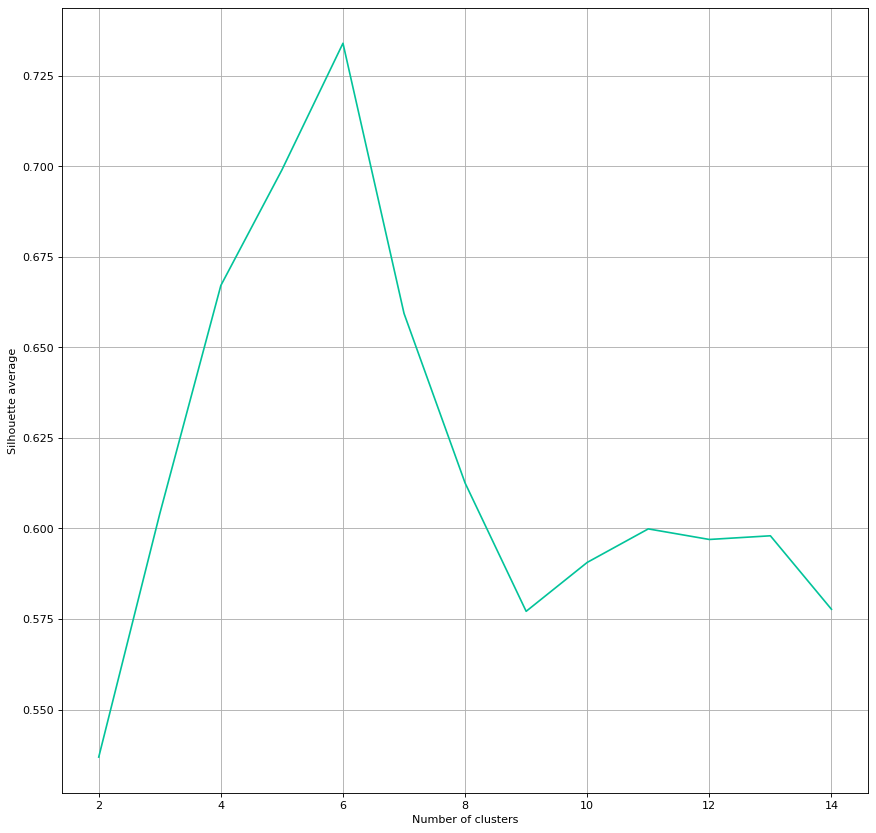

In [44]:
figure(num = None, figsize = (13, 13), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.plot(range_n_clusters, silhouette_array_PCA1, color = '#02c39a')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette average')
plt.grid()

In [45]:
kmeansPCA1 = KMeans(n_clusters=12, random_state=0).fit(prinComp1)
PCA1clabels = kmeansPCA1.fit_predict(prinComp1)
PCA1centers = kmeansPCA1.cluster_centers_

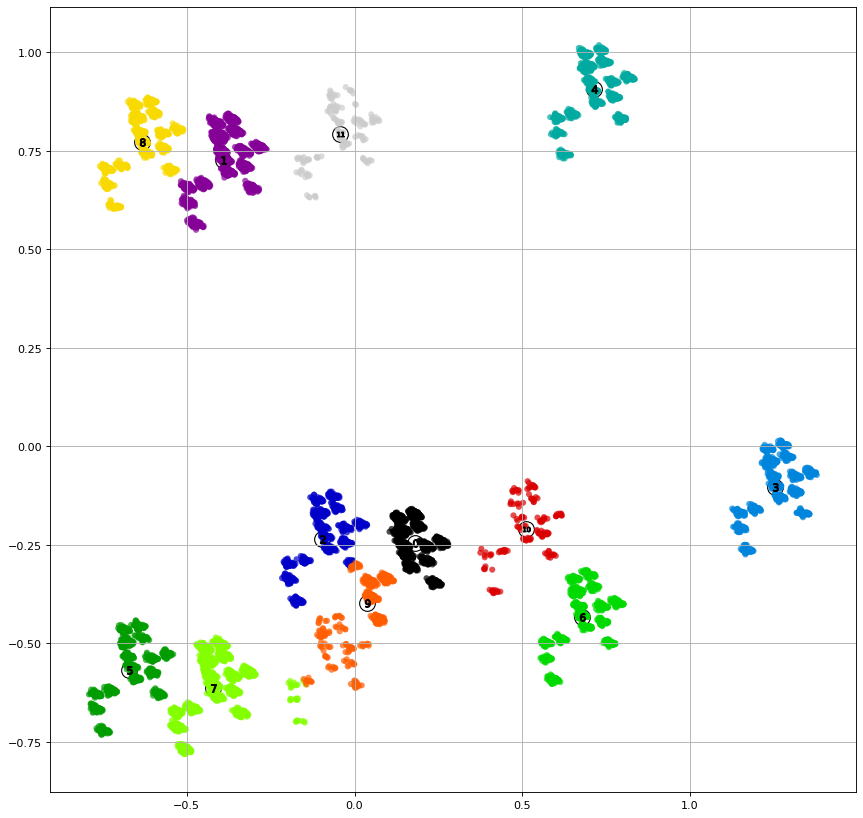

In [46]:
figure(num = None, figsize = (13, 13), dpi = 80, facecolor = 'w', edgecolor = 'k')
colors = cm.nipy_spectral(PCA1clabels.astype(float) / 11)
plt.scatter(PCA1centers[:, 0], PCA1centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
plt.scatter(prinComp1[:, 0], prinComp1[:, 1], marker='o', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

for i, c in enumerate(PCA1centers):
        plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
plt.grid()

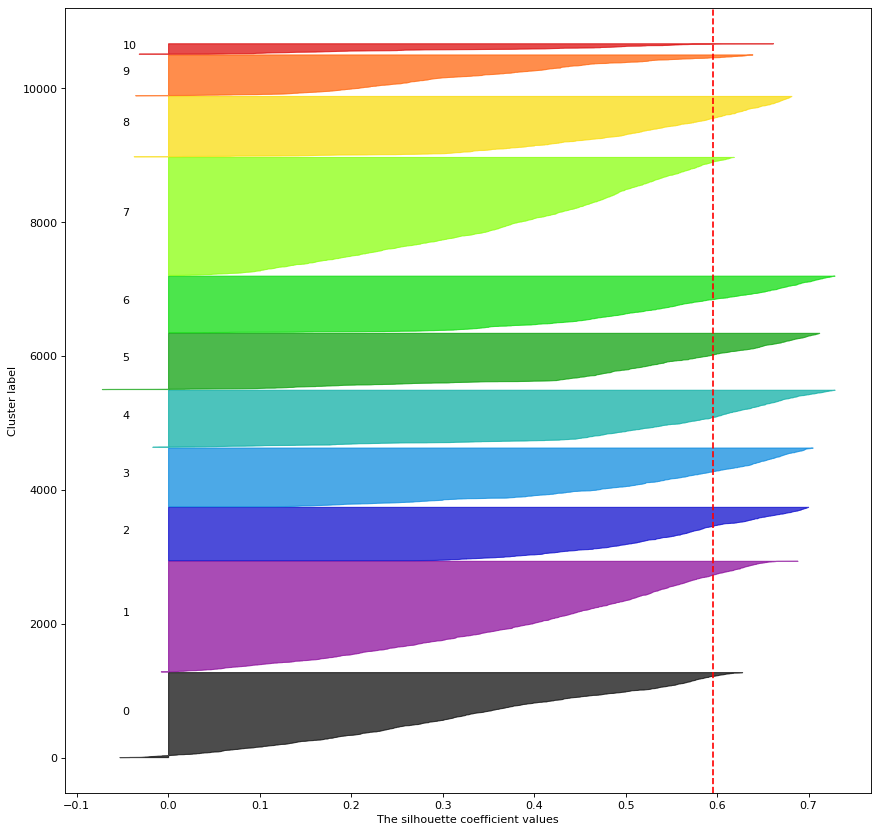

In [145]:
figure(num = None, figsize = (13, 13), dpi = 80, facecolor = 'w', edgecolor = 'k')
PCA1silhouette_avg = silhouette_score(prinComp1, PCA1clabels)

sample_silhouette_valuesPCA1 = silhouette_samples(prinComp1, PCA1clabels)

y_lower = 10
for i in range(11):    
    ith_cluster_silhouette_values = \
            sample_silhouette_values[PCA1clabels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]

    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 11)
        
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
plt.axvline(x=PCA1silhouette_avg, color="red", linestyle="--")
plt.savefig('sil1.png')

## Case study 2

In this line, we will analyze the set that does not have a ground-truth label. We will start by cleaning up the dataset.

In [159]:
df_set2 = set_2[test_india.columns.drop(['Name', 'Designation', 'people_ID'])]
col_names = ['Region', 'Gender', 'Married', 'Children', 'Occupation', 'Mode_transport', 'cases_1M', 'Deaths_1M',
       'comorbidity', 'Age', 'Coma_score', 'Pulmonary_score',
       'cardiological_pressure', 'Diuresis', 'Platelets', 'HBB', 'd_dimer',
       'Heart_rate', 'HDL_cholesterol', 'Charlson_Index', 'Blood_Glucose',
       'Insurance', 'salary', 'FT_month']
df_set2.columns = col_names
df_set2.shape

(14498, 24)

This is now what our set looks like.

In [160]:
df_set2.head()

Region  Gender Married  Children Occupation Mode_transport  cases_1M  \
0  Delhi  Female     YES         2     Driver         Public         4   
1  Delhi    Male     YES         2      Legal           Walk         4   
2  Delhi  Female     YES         2      Sales            Car         4   
3  Delhi  Female     YES         2      Sales            Car         4   
4  Delhi  Female     YES         2   Business            Car         4   

   Deaths_1M comorbidity  Age  ...  Platelets  HBB d_dimer  Heart_rate  \
0          1    Diabetes   52  ...        153  196     240          85   
1          1    Diabetes   53  ...         95  138     241          81   
2          1    Diabetes   35  ...         40  166     236          88   
3          1        None   31  ...         78   83     211          87   
4          1    Diabetes   51  ...        109  207     312          94   

   HDL_cholesterol  Charlson_Index  Blood_Glucose  Insurance   salary  \
0               53              17              3    3900000  1300000   
1               61               2              5    1800000  1300000   
2               47              24              3    5000000  2000000   
3               52              13              6    3100000   600000   
4               68              39              5    2300000  1500000   

   FT_month  
0         1  
1         1  
2         2  
3         2  
4         1  

[5 rows x 24 columns]

We check if there are missing values in the dataset.

In [161]:
df_set2.isna().sum().sum()

0

There are no missing values. Thus, we can proceed. We start preprocessing our data by replacing some attribute values with a binary transformation.

In [162]:
df_set2.Married.replace(to_replace=dict(YES=1, NO=0), inplace=True)
df_set2.Gender.replace(to_replace=dict(Male=0, Female=(1)), inplace=True)
df_set2['Pulmonary_score'].replace(['<100', '<200', '<300', '<400'], [100, 200, 300, 400], inplace=True)
df_set2.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Region  Gender  Married  Children Occupation Mode_transport  cases_1M  \
0  Delhi       1        1         2     Driver         Public         4   
1  Delhi       0        1         2      Legal           Walk         4   
2  Delhi       1        1         2      Sales            Car         4   
3  Delhi       1        1         2      Sales            Car         4   
4  Delhi       1        1         2   Business            Car         4   

   Deaths_1M comorbidity  Age  ...  Platelets  HBB d_dimer  Heart_rate  \
0          1    Diabetes   52  ...        153  196     240          85   
1          1    Diabetes   53  ...         95  138     241          81   
2          1    Diabetes   35  ...         40  166     236          88   
3          1        None   31  ...         78   83     211          87   
4          1    Diabetes   51  ...        109  207     312          94   

   HDL_cholesterol  Charlson_Index  Blood_Glucose  Insurance   salary  \
0               53              17              3    3900000  1300000   
1               61               2              5    1800000  1300000   
2               47              24              3    5000000  2000000   
3               52              13              6    3100000   600000   
4               68              39              5    2300000  1500000   

   FT_month  
0         1  
1         1  
2         2  
3         2  
4         1  

[5 rows x 24 columns]

We encode and transform the attributes. We use One hot encoder from scikit learn on the categorical attributes as suggested in [2], and use a logaritmic transformation on the numerical attributes as stated in [3].

In [52]:
enc_cat_data2 = enc.transform(df_set2.loc[:, msk_cat])
enc_num_data2 = np.log10(df_set2.loc[:, msk_num] + 1)
set2_enc = scipy.sparse.hstack([enc_num_data2, enc_cat_data2])
set2_enc.shape

(14498, 44)

Then, we leverage MDS. 

In [ ]:
results_test = MDS(n_components = 2, metric = True, n_init = 4, max_iter = 300, verbose = 0, eps = 0.001, n_jobs = None, random_state = 970, dissimilarity = 'euclidean').fit(set2_enc.toarray())

It takes a long time to obtain these results, therefore, we save them so as to save time in further tests.

In [53]:
MDS_set2 = pd.read_csv('set2_MDS.csv')

In [54]:
MDS_set2 = MDS_set2.iloc[:,1:]
MDS_set2.head()

0         1
0  1.298629 -1.618852
1 -0.805021 -2.180531
2  2.302778 -0.060717
3  0.650912  1.944614
4  1.694606  1.249136

Now, we visualize the data.

In [55]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

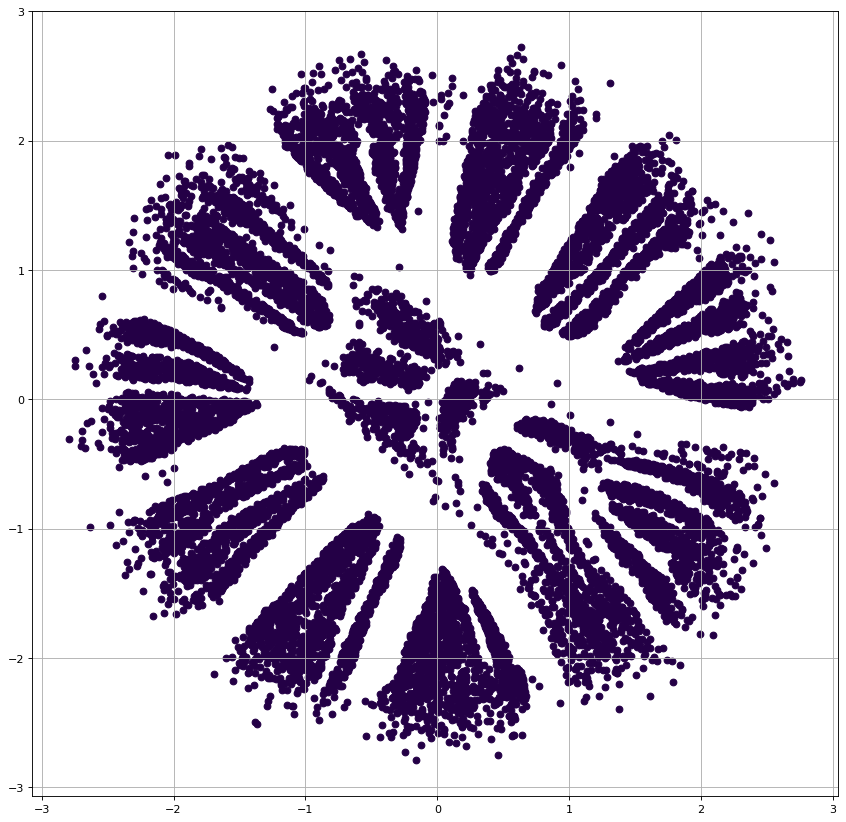

In [140]:
figure(num = None, figsize = (13, 13), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.scatter(MDS_set2.iloc[:, 0], MDS_set2.iloc[:, 1], marker='o', color='#240046')
plt.grid()
plt.savefig('MDS2.png')
plt.show()

In [57]:
silhouette_array2 = []
range_n_clusters2 = range(2,16)
for n_clusters in range_n_clusters2:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels2 = clusterer.fit_predict(MDS_set2)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg2 = silhouette_score(MDS_set2, cluster_labels2)
    silhouette_array2.append(silhouette_avg2)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg2)

For n_clusters = 2 The average silhouette_score is : 0.36645759463265276
For n_clusters = 3 The average silhouette_score is : 0.4091248668510951
For n_clusters = 4 The average silhouette_score is : 0.41050730062558544
For n_clusters = 5 The average silhouette_score is : 0.408906636587998
For n_clusters = 6 The average silhouette_score is : 0.42649729341960524
For n_clusters = 7 The average silhouette_score is : 0.44501448235403324
For n_clusters = 8 The average silhouette_score is : 0.43268210961552955
For n_clusters = 9 The average silhouette_score is : 0.4263211521602686
For n_clusters = 10 The average silhouette_score is : 0.4382049075187403
For n_clusters = 11 The average silhouette_score is : 0.44782294814206625
For n_clusters = 12 The average silhouette_score is : 0.45602902936584006
For n_clusters = 13 The average silhouette_score is : 0.4605856557682552
For n_clusters = 14 The average silhouette_score is : 0.46137687810059835
For n_clusters = 15 The average silhouette_score is 

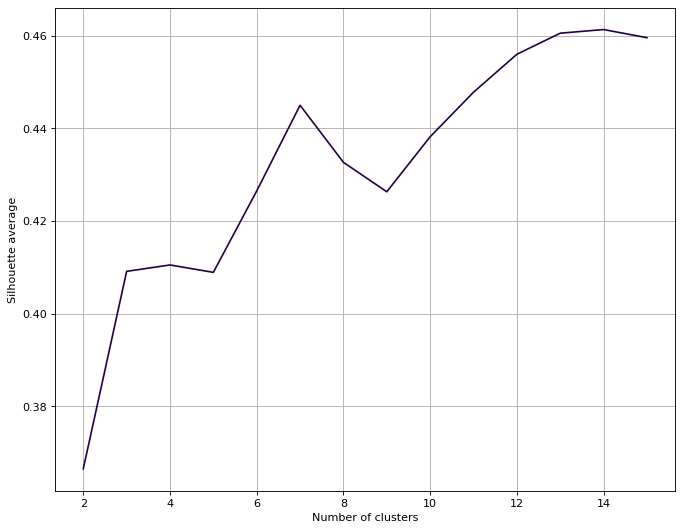

In [138]:
figure(num = None, figsize = (10, 8), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.plot(range_n_clusters2, silhouette_array2, color = '#240046')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette average')
plt.savefig('kvss2.png')
plt.grid()

In [59]:
import matplotlib.cm as cm

In [60]:
kmeans2 = KMeans(n_clusters=13, random_state=0).fit(MDS_set2)
cluster_labels2 = kmeans2.fit_predict(MDS_set2)
centers2 = kmeans2.cluster_centers_

In [61]:
c2_labels = pd.DataFrame(data = cluster_labels2)
c_labels2 = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]
values = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm']
c2_labels = c2_labels.replace(to_replace = c_labels2, value = values)
c2_labels.to_csv('labels_MDS2.csv')

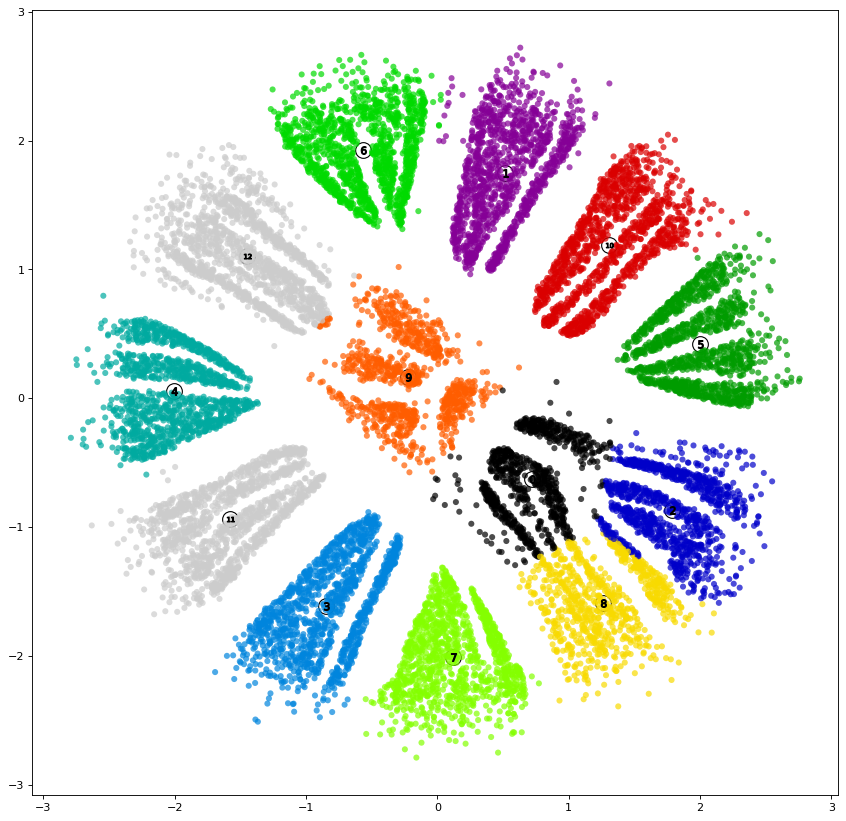

In [142]:
figure(num = None, figsize = (13, 13), dpi = 80, facecolor = 'w', edgecolor = 'k')
colors2 = cm.nipy_spectral(cluster_labels2.astype(float) / 11)
plt.scatter(centers2[:, 0], centers2[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
plt.scatter(MDS_set2.values[:, 0], MDS_set2.values[:, 1], marker='o', s=30, lw=0, alpha=0.7,
                c=colors2, edgecolor='k')

for i, c in enumerate(centers2):
        plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
plt.savefig('clusters2.png')

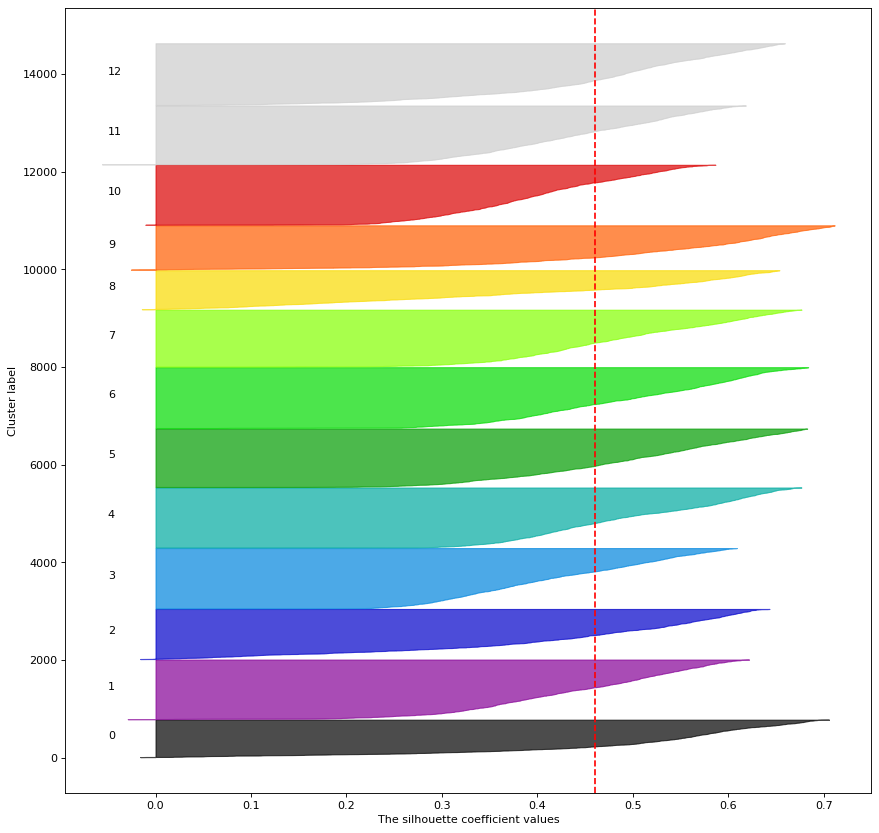

In [144]:
figure(num = None, figsize = (13, 13), dpi = 80, facecolor = 'w', edgecolor = 'k')
silhouette_avg2 = silhouette_score(MDS_set2, cluster_labels2)

sample_silhouette_values2 = silhouette_samples(MDS_set2, cluster_labels2)

y_lower = 10
for i in range(13):    
    ith_cluster_silhouette_values = \
            sample_silhouette_values2[cluster_labels2 == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]

    y_upper = y_lower + size_cluster_i

    color2 = cm.nipy_spectral(float(i) / 11)
        
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color2, edgecolor=color2, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg2, color="red", linestyle="--")
plt.savefig('sil2.png')

Additionally, we aim to predict the probability of infection for set 2. This subset does not have ground-truth values. Thus, the experiments we will conduct to predict these values will be performed on set 1.

Now, we split set 1 into a training set per se and a test set that we will use to validate our model. Thus, the pipeline is:
- Train a regression model on the training set (fraction of set 1).
- Evaluate performance on test set (fraction of set 1). 
- Predict probability of infection for set 2 (this data will not be previously seen by the model and it does not have a target).

In [79]:
set1 = pd.read_csv('completeData_train_india.csv')

In [81]:
X_train = set1.sample(frac = 0.75, random_state = 0)
toy_test = set1.drop(train.index)

X_train = X_train.iloc[:, :-1]
print(X_train.shape, toy_test.shape)
train.head()

(8036, 24) (2678, 25)


Region  Gender Married  Children Occupation Mode_transport  \
4041          Delhi  Female     YES         2     Driver           Walk   
9305          Delhi    Male     YES         2    Cleaner         Public   
10262     Bengaluru    Male     YES         0      Legal            Car   
6057   Bhubaneshwar    Male     YES         1     Driver         Public   
7071     Chandigarh    Male     YES         1      Legal           Walk   

       cases_1M  Deaths_1M   comorbidity  Age  ...  HBB d_dimer Heart_rate  \
4041          4          1      Diabetes   40  ...  178     288         86   
9305          4          1      Diabetes   33  ...  104     304         95   
10262         8          2  Hypertension   45  ...  193     289         63   
6057          2          0          None   29  ...  192     216         62   
7071          2          0      Diabetes   44  ...  113     265         59   

       HDL_cholesterol  Charlson_Index  Blood_Glucose  Insurance   salary  \
4041                41              40              5  4000000.0  2200000   
9305                37              35              5  4000000.0  1500000   
10262               58              25              5   400000.0  1900000   
6057                44               0              6  3000000.0  2100000   
7071                56               5              4  2800000.0   300000   

       FT_month  Infect_Prob  
4041          1    53.072883  
9305          2    52.406560  
10262         2    47.567603  
6057          1    48.914593  
7071          1    49.432939  

[5 rows x 25 columns]

In [82]:
toy_test.head()

Region  Gender Married  Children     Occupation Mode_transport  \
0   Bhubaneshwar  Female     YES         1         Farmer         Public   
2   Bhubaneshwar  Female      NO         1        Cleaner         Public   
13  Bhubaneshwar  Female     YES         2       Business         Public   
21  Bhubaneshwar  Female      NO         2  Manufacturing         Public   
25  Bhubaneshwar  Female     YES         0         Farmer         Public   

    cases_1M  Deaths_1M             comorbidity  Age  ...  HBB d_dimer  \
0          2          0            Hypertension   68  ...   93     233   
2          2          0                    None   19  ...  137     213   
13         2          0            Hypertension   52  ...   48     333   
21         2          0                    None   20  ...   32     343   
25         2          0  Coronary Heart Disease   51  ...   96     291   

   Heart_rate  HDL_cholesterol  Charlson_Index  Blood_Glucose  Insurance  \
0          82               58              27              7  3600000.0   
2          77               43              40              6  3400000.0   
13         99               51              31              5  3500000.0   
21         56               40              20              5  3700000.0   
25         95               67              39              6  3100000.0   

     salary  FT_month  Infect_Prob  
0   1300000         2    49.135010  
2    900000         1    73.224000  
13  2200000         2    48.948107  
21  1400000         2    79.081920  
25  2000000         2    48.050225  

[5 rows x 25 columns]

We start preprocessing our data by replacing some attribute values with a binary transformation.

In [83]:
X_train.Married.replace(to_replace=dict(YES=1, NO=0), inplace=True)
X_train.Gender.replace(to_replace=dict(Male=0, Female=1), inplace=True)
X_train['Pulmonary_score'].replace(['<100', '<200', '<300', '<400'], [100, 200, 300, 400], inplace=True)
X_train.head()

Region  Gender  Married  Children Occupation Mode_transport  \
4041          Delhi       1        1         2     Driver           Walk   
9305          Delhi       0        1         2    Cleaner         Public   
10262     Bengaluru       0        1         0      Legal            Car   
6057   Bhubaneshwar       0        1         1     Driver         Public   
7071     Chandigarh       0        1         1      Legal           Walk   

       cases_1M  Deaths_1M   comorbidity  Age  ...  Platelets  HBB d_dimer  \
4041          4          1      Diabetes   40  ...        101  178     288   
9305          4          1      Diabetes   33  ...         48  104     304   
10262         8          2  Hypertension   45  ...         29  193     289   
6057          2          0          None   29  ...         77  192     216   
7071          2          0      Diabetes   44  ...         83  113     265   

       Heart_rate  HDL_cholesterol  Charlson_Index  Blood_Glucose  Insurance  \
4041           86               41              40              5  4000000.0   
9305           95               37              35              5  4000000.0   
10262          63               58              25              5   400000.0   
6057           62               44               0              6  3000000.0   
7071           59               56               5              4  2800000.0   

        salary  FT_month  
4041   2200000         1  
9305   1500000         2  
10262  1900000         2  
6057   2100000         1  
7071    300000         1  

[5 rows x 24 columns]

Now, we create some masks for encoding.

In [84]:
msk_cat = X_train.dtypes == 'object'
msk_num = X_train.dtypes != 'object'

We encode and transform the attributes. We use One hot encoder from scikit learn on the categorical attributes as suggested in [2], and use a logaritmic transformation on the numerical attributes as stated in [3].

In [85]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import scipy.sparse

In [86]:
enc = OneHotEncoder(sparse = True, handle_unknown = 'ignore')
enc_cat_data = enc.fit_transform(X_train.loc[:, msk_cat])
enc_num_data = np.log10(X_train.loc[:, msk_num] + 1)
X_train_enc = scipy.sparse.hstack([enc_num_data, enc_cat_data])
X_train_enc.shape

(8036, 44)

Now, we create a target vector and apply the logaritmic transformation as well.

In [87]:
y_original = train.iloc[:,-1]
y_train = np.log10(y_original + 1)
y_train.head()
y_train.shape

(8036,)

After transforming the data, it has 44 attributes. Thus, we used PCA to select a subset of those attributes. After this procedure, our training set has 36 out of 44 initial attributes.

In [88]:
from sklearn.decomposition import PCA

In [89]:
pca = PCA(whiten = True)
pca.fit(X_train_enc.toarray())
variance = pd.DataFrame(pca.explained_variance_ratio_)
cusum = np.cumsum(pca.explained_variance_ratio_)

In [90]:
n_attributes = sum(cusum < 0.999999999)
pca = PCA(n_components = n_attributes, whiten = True)
pca = pca.fit(X_train_enc.toarray())
X_train_PCA = pca.transform(X_train_enc.toarray())
X_train_PCA.shape

(8036, 35)

To choose the regression model, we utilized a 5-Fold cross validation on the training set. We tested a variety of regression models and used the R^2 score to evaluate its performance.

In [91]:
from sklearn import metrics
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [92]:
def regressions(train, y):
    
    results = {}
    
    def try_model(clf):
        cv = KFold(n_splits=5, shuffle=True, random_state=45)
        r2 = metrics.make_scorer(metrics.r2_score)
        r2_val_score = cross_val_score(clf, train, y, cv=cv, scoring=r2)
        scores = [r2_val_score.mean()]
        return scores
  
    clf = linear_model.LinearRegression()
    results['Linear'] = try_model(clf)
    print('Linear Regression, done')

    clf = linear_model.Ridge(alpha = 10)
    results['Ridge'] = try_model(clf)
    print('Ridge Regression, done')

    clf = linear_model.BayesianRidge()
    results['Bayesian Ridge'] = try_model(clf)
    print('Bayesian Ridge Regression, done')

    clf = linear_model.HuberRegressor()
    results['Hubber'] = try_model(clf)
    print('Hubber Regression, done')

    clf = linear_model.Lasso(alpha=1e-4)
    results['Lasso'] = try_model(clf)
    print('Lasso regression, done')

    clf = BaggingRegressor()
    results['Bagging'] = try_model(clf)
    print('Bagging Regressor, done')

    clf = RandomForestRegressor()
    results['RandomForest'] = try_model(clf)
    print('Random Forest Regressor, done')

    clf = AdaBoostRegressor()
    results['AdaBoost'] = try_model(clf)
    print('AdaBoost Regressor, done')

    clf = svm.SVR()
    results['SVM RBF'] = try_model(clf)
    print('SVM RBF, done')

    clf = svm.SVR(kernel="linear")
    results['SVM Linear'] = try_model(clf)
    print('SVM Linear regression, done')
    
    print(results)

In [93]:
regressions(X_train_PCA, y_train)

Linear Regression, done
Ridge Regression, done
Bayesian Ridge Regression, done
Hubber Regression, done
Lasso regression, done
Bagging Regressor, done
Random Forest Regressor, done
AdaBoost Regressor, done
SVM RBF, done
SVM Linear regression, done
{'Linear': [0.2110730936580621], 'Ridge': [0.21108749981093897], 'Bayesian Ridge': [0.21116950609672475], 'Hubber': [0.1212131738899884], 'Lasso': [0.21145935102822158], 'Bagging': [0.16501861152386396], 'RandomForest': [0.2452323428073091], 'AdaBoost': [0.19636790552814123], 'SVM RBF': [-0.11744599771180683], 'SVM Linear': [0.028355235601461425]}


Among them all, the highest R^2 value is obtained with the Random Forest Regressor. Thus, we iterate over the features and depth to find the optimal set of parameters to actually train our model.

In [94]:
import math

In [95]:
seed = 0
scores = []
features = ['auto', 'sqrt', 'log2', None]
max_score = - math.inf

for feature in features:
    for depth in range(1, X_train_PCA.shape[1]):
        rf_reg = RandomForestRegressor(max_depth = depth, max_features = feature, random_state = seed)
        rf_reg.fit(X_train_PCA, y_train)
        score = rf_reg.score(X_train_PCA, y_train)
        score = np.round(score, 6)
        scores.append(score)

    if score > max_score:
        max_score = score
        best_depth = depth
        best_feature = feature 

We plot the results.

In [96]:
import matplotlib.pyplot as plt

Best CV score is 0.899278 with depth of 34 and with the selection of features as auto.


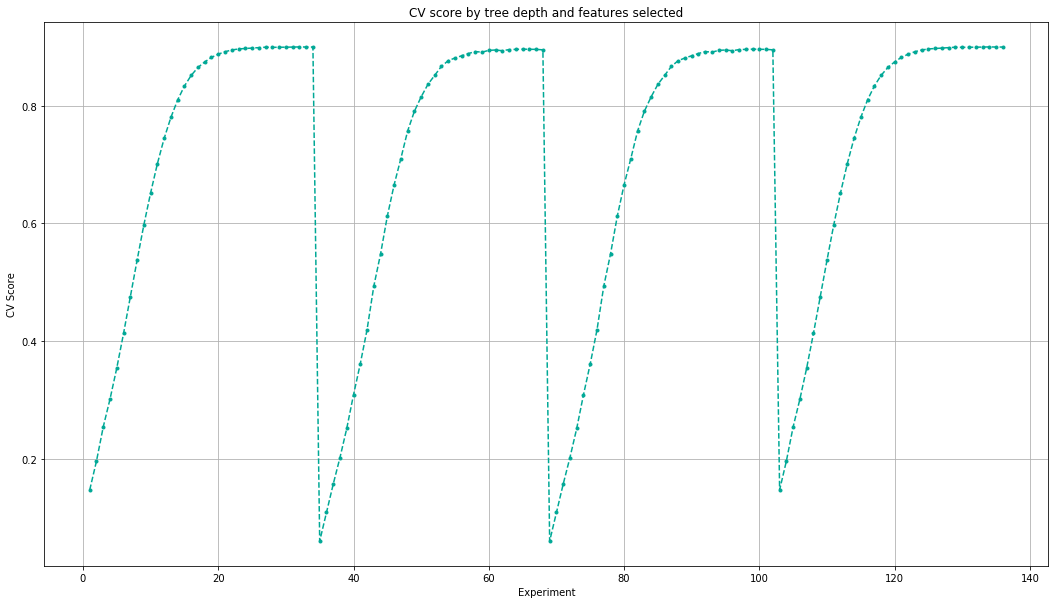

In [97]:
print('Best CV score is {} with depth of {} and with the selection of features as {}.'.format(max_score, best_depth, best_feature))

plt.figure(figsize=(18, 10))
plt.plot(range(1, 137), scores, color ='#00a896', linestyle = 'dashed', marker='o',
         markerfacecolor = '#00a896', markersize=3)
plt.title('CV score by tree depth and features selected')
plt.xlabel('Experiment')
plt.ylabel('CV Score')
plt.grid()
plt.savefig('CV_SCORE.png')

Now, we actually train the model with the parameters we obtained from the previous cross-validation procedure.

In [98]:
model = RandomForestRegressor(max_depth = 34, max_features='auto', random_state=0)
model.fit(X_train_PCA, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=34, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

To evaluate its performance, we use the toy test set (that subset from the training set we have not used yet).

In [99]:
X_test = toy_test.iloc[:, :-1]
y_true_original = toy_test.iloc[:,-1]
y_true = np.log10(y_true_original + 1)

# Encode test set
X_test.Married.replace(to_replace=dict(YES=1, NO=0), inplace=True)
X_test.Gender.replace(to_replace=dict(Male=0, Female=(1)), inplace=True)
X_test['Pulmonary_score'].replace(['<100', '<200', '<300', '<400'], [100, 200, 300, 400], inplace=True)

X_cat = X_test.loc[:, msk_cat]
X_num = X_test.loc[:, msk_num]
enc_num_data = np.log10(X_num.loc[:, msk_num] + 1)

enc_cat_data = enc.transform(X_cat)

X_test_enc = scipy.sparse.hstack([enc_num_data, enc_cat_data])

X_test_enc = X_test_enc.toarray()
X_test_PCA = pca.transform(X_test_enc)

print(X_test.shape, X_test_PCA.shape, y_true.shape)

(2678, 24) (2678, 35) (2678,)


Now, we predict target values.

In [100]:
y_pred = model.predict(X_test_PCA)

Finally, we evaluate the perfomance of the model.

In [101]:
R2 = metrics.r2_score(y_true, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))

print('R2 for Regression model: \n', R2)
print('RMSE for Regression model: \n', rmse)

R2 for Regression model: 
 0.2908030043911163
RMSE for Regression model: 
 0.062572060671718


Up to this point, the R^2 score shows that the performance of the regression model is not competitive. According to [6], larger values of R^2 are an indication of a strong relationship between the independent and the dependent variable. Nevertheless, in practice, a small R^2 may indicate that the dependent variable might be partly influenced by other factors.

Thus, we will predict the values for set 2 and extract information with clustering techniques as we did previously with set 1. We will thus use the MDS data we have already extracted from set 2. 

We start by predicting the probability for set 2. 

In [107]:
set2_pca = pca.transform(set2_enc.toarray())
set2_pca.shape

(14498, 35)

In [110]:
y_set2 = model.predict(set2_pca)
len(y_set2)

14498

Initially, we will show how the probability of infection varies within the whole data. Thus, we will use the probability associated to each observation and show this values with a heatmap.

In [135]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
colors = ['#e0aaff', '#240046']
cmap2 = LinearSegmentedColormap.from_list("mycmap", colors)

We normalize the probabilities first.

In [114]:
n_probabilities2 = y_set2 / sum(y_set2)

Now, we show the results. Light tones are related to low probabilities and darker tones to high probabilities.

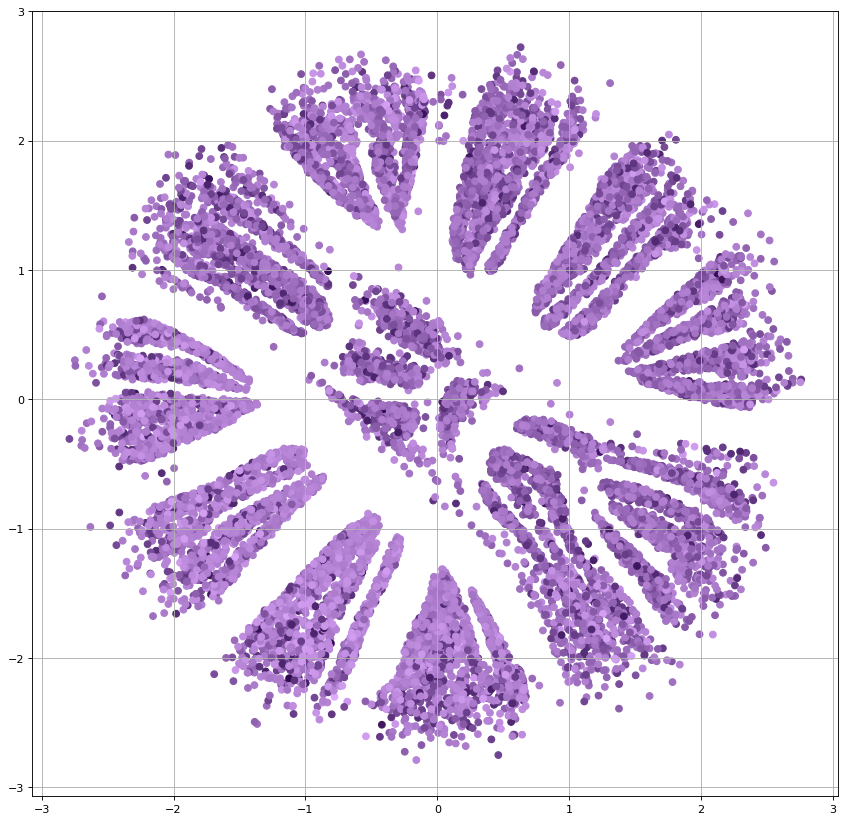

In [136]:
figure(num = None, figsize = (13, 13), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.scatter(MDS_set2.values[:, 0], MDS_set2.values[:, 1], c = n_probabilities2, cmap = cmap2 , marker='o')
plt.savefig('prob2.png')
plt.grid()

We will proceed to visualize how the probability changes cluster by cluster.

In [118]:
u_labels2 = set(cluster_labels2)

In [119]:
for label in u_labels2:
    index = 'ind2_' + str(label)
    objs = 'obs2_' + str(label)
    pr = 'prob2_' + str(label)
    vars()[index] = []
    vars()[objs] = []
    for i in range(len(cluster_labels)):
        if cluster_labels2[i] == label:
            vars()[index].append(i)
            vars()[objs].append(MDS_set2.values[i])
    
    vars()[objs] = np.array(vars()[objs])
    vars()[pr] = n_probabilities2[vars()[index]]

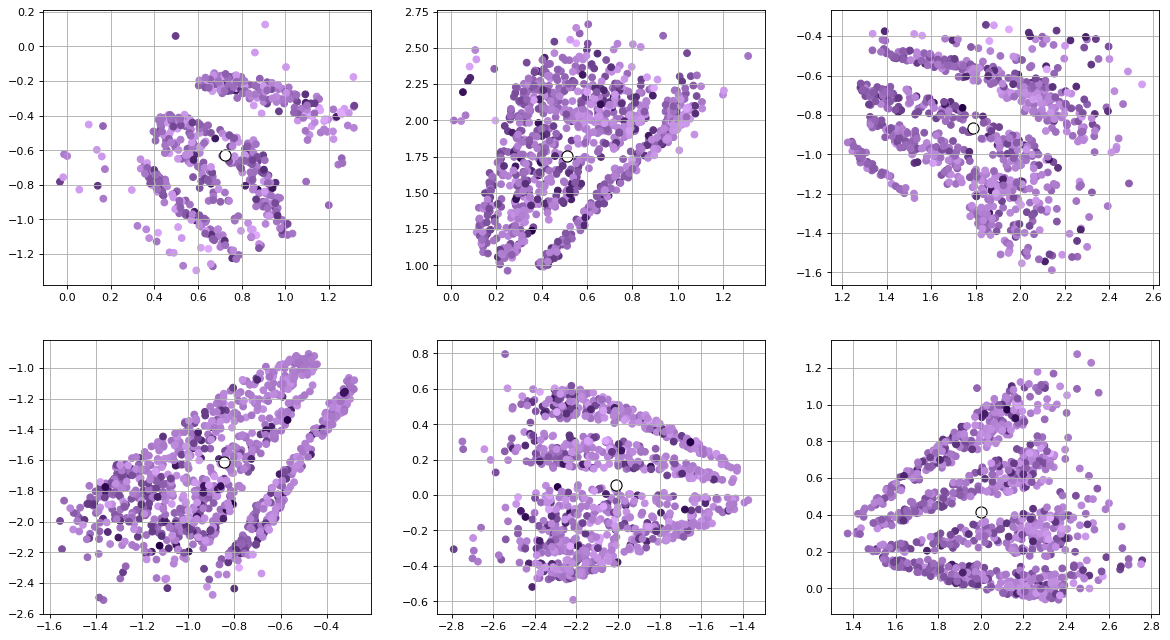

In [155]:
figure(num = None, figsize = (18, 10), dpi = 80, facecolor = 'w', edgecolor = 'k')

plt.subplot(231)
plt.scatter(obs2_0[:, 0], obs2_0[:, 1], c = prob2_0, cmap = cmap2, marker='o')
plt.scatter(centers2[0, 0], centers2[0, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.subplot(232)
plt.scatter(obs2_1[:, 0], obs2_1[:, 1], c = prob2_1, cmap = cmap2, marker='o')
plt.scatter(centers2[1, 0], centers2[1, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.subplot(233)
plt.scatter(obs2_2[:, 0], obs2_2[:, 1], c = prob2_2, cmap = cmap2, marker='o')
plt.scatter(centers2[2, 0], centers2[2, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.subplot(234)
plt.scatter(obs2_3[:, 0], obs2_3[:, 1], c = prob2_3, cmap = cmap2, marker='o')
plt.scatter(centers2[3, 0], centers2[3, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.subplot(235)
plt.scatter(obs2_4[:, 0], obs2_4[:, 1], c = prob2_4, cmap = cmap2, marker='o')
plt.scatter(centers2[4, 0], centers2[4, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.subplot(236)
plt.scatter(obs2_5[:, 0], obs2_5[:, 1], c = prob2_5, cmap = cmap2, marker='o')
plt.scatter(centers2[5, 0], centers2[5, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.savefig('cprob2a.png')

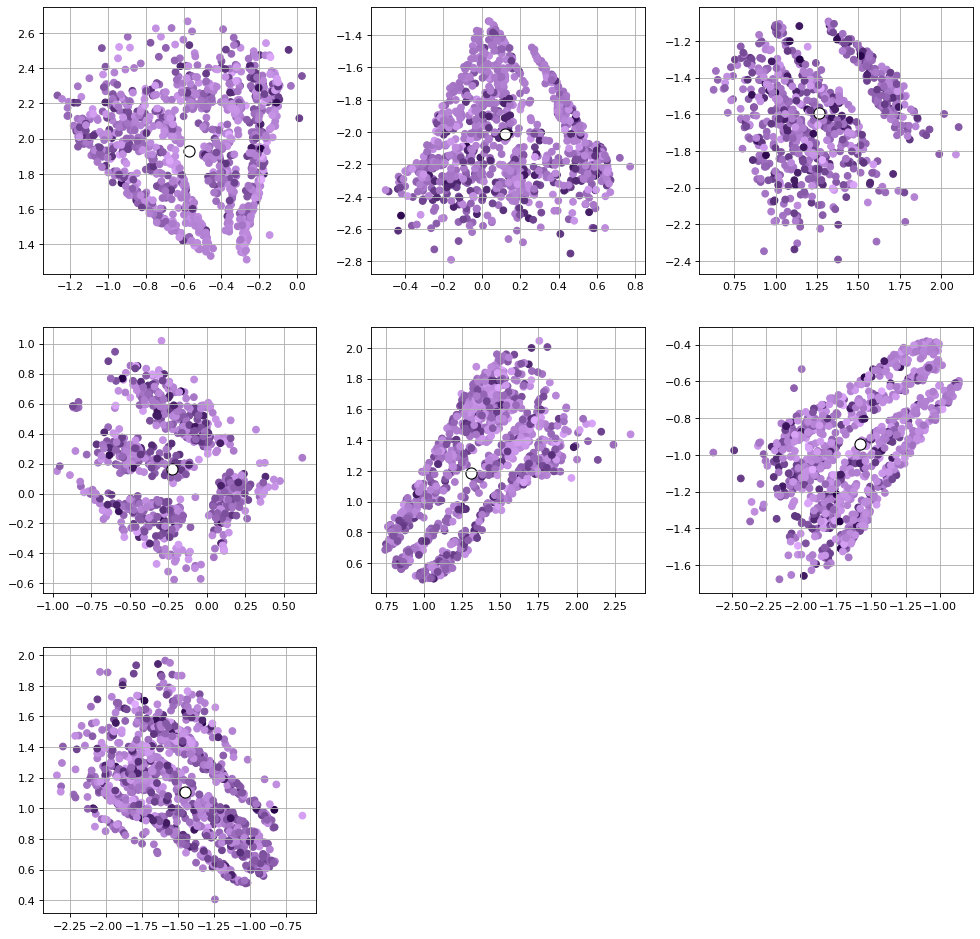

In [156]:
figure(num = None, figsize = (15, 15), dpi = 80, facecolor = 'w', edgecolor = 'k')

plt.subplot(331)
plt.scatter(obs2_6[:, 0], obs2_6[:, 1], c = prob2_6, cmap = cmap2, marker='o')
plt.scatter(centers2[6, 0], centers2[6, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.subplot(332)
plt.scatter(obs2_7[:, 0], obs2_7[:, 1], c = prob2_7, cmap = cmap2, marker='o')
plt.scatter(centers2[7, 0], centers2[7, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.subplot(333)
plt.scatter(obs2_8[:, 0], obs2_8[:, 1], c = prob2_8, cmap = cmap2, marker='o')
plt.scatter(centers2[8, 0], centers2[8, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.subplot(334)
plt.scatter(obs2_9[:, 0], obs2_9[:, 1], c = prob2_9, cmap = cmap2, marker='o')
plt.scatter(centers2[9, 0], centers2[9, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.subplot(335)
plt.scatter(obs2_10[:, 0], obs2_10[:, 1], c = prob2_10, cmap = cmap2, marker='o')
plt.scatter(centers2[10, 0], centers2[10, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.subplot(336)
plt.scatter(obs2_11[:, 0], obs2_11[:, 1], c = prob2_11, cmap = cmap2, marker='o')
plt.scatter(centers2[11, 0], centers2[11, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.subplot(337)
plt.scatter(obs2_12[:, 0], obs2_12[:, 1], c = prob2_12, cmap = cmap2, marker='o')
plt.scatter(centers2[12, 0], centers2[12, 1], marker='o', c ="white", alpha=1, s=100, edgecolor='k')
plt.grid()

plt.savefig('cprob2b.png')

## References

[1] van Buuren, S., & Groothuis-Oudshoorn, K. (2011). mice: Multivariate Imputation by Chained Equations in R. Journal of Statistical Software, 45(3), 1 - 67. 10.18637/jss.v045.i03

[2] Potdar, Kedar & Pardawala, Taher & Pai, Chinmay. (2017). A Comparative Study of Categorical Variable Encoding Techniques for Neural Network Classifiers. International Journal of Computer Applications. 175. 7-9. 10.5120/ijca2017915495. 

[3] Wickham, Hadley, 2014. "Tidy Data," Journal of Statistical Software, Foundation for Open Access Statistics, vol. 59(i10).

[4] Nasir Saeed, Haewoon Nam, Mian Imtiaz Ul Haq, and Dost Bhatti Muhammad Saqib. 2018. A Survey on Multidimensional Scaling. ACM Comput. Surv. 51, 3, Article 47 (July 2018), 25 pages. 10.1145/3178155

[5] António M. Lopes, José P. Andrade, J.A. Tenreiro Machado. Multidimensional scaling analysis of virus diseases. Computer Methods and Programs in Biomedicine. Volume 131. 2016. Pages 97-110. 10.1016/j.cmpb.2016.03.029.

[6] Andrew F. Siegel, Chapter 11 - Correlation and Regression: Measuring and Predicting Relationships, Editor(s): Andrew F. Siegel, Practical Business Statistics, Academic Press, 2012, pp. 291-345, doi: 10.1016/B978-0-12-385208-3.00011-0.